In [1]:
#default_exp dist

## Import modules that are only used in documentation, nbdev related stuff like testing using assert and more generally inside this notebook (not going to src).

In [2]:
#hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2 #autoreload to make code from other modules get updated online inside notebook

import sys
sys.path.append('..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root

#DO NOT EDIT

In [3]:
#hide

#Internal Imports
#imports that are going to be used only during development and are not intended to be loaded inside the generated modules.
#for example: use imported modules to generate graphs for documentation, but lib is unused in actual package

#import ...

# Code

In [4]:
#export
import numpy as np
from scipy import stats

from sklearn.base import DensityMixin, BaseEstimator
from functools import partial
from sklearn.utils import check_array


In [232]:
#export
def get_distribution_var_factor_jaccard(jac_dists, min_var_factor = 1e-2, alpha = 1, func = 'log'):
    '''
    gets the variance factor of the "point distribution" given a jaccard distance from
    the query point
    
    to get the actual variance, use the variance factor alongside the variance of the
    observed variable in the neighbor points.
    
    example:
    
    get the 30 nearest neighbors, calculat their variance along some axis,
    then calculate the variance factor of each point and then multiply to get the
    "point variance in the contribution" for each point
    
    functions to test:
    tangent(x), 1/x, min_var - log(1-x)
    '''    
    funcs = ['log', 'inverse_dist', 'constant']
    assert min_var_factor > 0
    assert alpha > 0
    
    #if sim = 1, var_factor = min_var_factor, if sim -> 0, var_factor -> inf
    if func == 'log':
        var_factor = min_var_factor - alpha*np.log(1-jac_dists)  
    elif func == 'inverse_dist':
        var_factor = min_var_factor/(1-jac_dists)**alpha
    elif func == 'constant':
        var_factor = np.ones(jac_dist.shape)
    return var_factor

def pointwise_variance(values, jac_dists, min_var_factor = 1e-2, alpha = 1, variance_mapper = 'log'):
    '''
    gets the pointwise variance for each neighbor of a given point, considering
    the variance of the neighborhood and the variance factor of each point 
    
    each point contributes to the estimation of the queried point, but this contribution
    has a variance associated with how much this point is alike the queried point. in this sense
    pointwise variance is defined, as the variance of the contribution of each point, given the 
    variance of all the points and how similar the points in the neighborhood are to the queried point
    
    the variance of the contribution os different from the (sampling)weight of the point,
    since points with lower similarity will have a higher variance, but will be less likely to be sampled
    '''    
    
    #global variance is calculated with the wieghted full neighbors instead of the sampled values, in order to avoid 0 variance
    #if a single value is sampled
            
    var_factor = get_distribution_var_factor_jaccard(jac_dists, min_var_factor, alpha, func = variance_mapper)            
    var = np.cov(values, rowvar = False, aweights=(1- jac_dists.flatten())**alpha) #global variance weights are proportional to point similarities, not distance        
    if var.ndim > 1:        
        broadcasted_var_factor = jac_dists.reshape(jac_dists.shape[0],1)[:, np.newaxis]
        pointwise_variance = broadcasted_var_factor*var
    else:
        pointwise_variance = var_factor*var
    return pointwise_variance

Text(0, 0.5, 'var_factor')

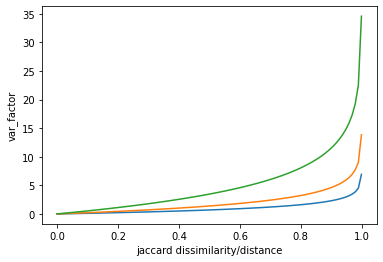

In [249]:
import matplotlib.pyplot as plt
%matplotlib inline

jac_dists = np.linspace(0,0.999, 100)
plt.plot(jac_dists, get_distribution_var_factor_jaccard(jac_dists, alpha = 1))
plt.plot(jac_dists, get_distribution_var_factor_jaccard(jac_dists, alpha = 2))
plt.plot(jac_dists, get_distribution_var_factor_jaccard(jac_dists, alpha = 5))

plt.xlabel('jaccard dissimilarity/distance')
plt.ylabel('var_factor')

In [583]:
#export
def estimate_mean_and_variance_from_neighbors_mixture(
    neighborhood_values,
    jac_dists,        
    alpha = 1,
    variance_mapper = 'log',
    min_var_factor = 1e-2,    
):
    '''
    refs 
    https://stats.stackexchange.com/questions/16608/what-is-the-variance-of-the-weighted-mixture-of-two-gaussians
    https://math.stackexchange.com/questions/195911/calculation-of-the-covariance-of-gaussian-mixtures
    
    at the end of the day, impelmented covaraince scaling according to scaling in the diagonal of covariance matrix
    for multidimensional case
    '''    
    
    weights = ((1-jac_dists)**alpha)
    weights = weights/weights.sum(axis = 0) #normalize
    
    neighborhood_values = check_array(neighborhood_values)
    
    if neighborhood_values.shape[-1] == 1:
        neighborhood_values = neighborhood_values.flatten()
    
    mean = np.average(neighborhood_values, weights = weights, axis = 0)    
    
    pw_var = pointwise_variance(
        values = neighborhood_values,
        jac_dists = jac_dists,
        min_var_factor = min_var_factor,
        alpha = alpha,
        variance_mapper = variance_mapper
    )
    
    
    #handle broadcasting
    extra_dims_n = pw_var.ndim - neighborhood_values.ndim
    extra_dims_w = pw_var.ndim - weights.ndim
    
    if extra_dims_n > 0:
        neighborhood_values = neighborhood_values.reshape(*neighborhood_values.shape, *extra_dims_n*[1])        
    if extra_dims_w > 0:
        weights = weights.reshape(*weights.shape, *extra_dims_w*[1])
    
    
    
    #var = np.sum(weights*pw_var, axis = 0)
    wvar = np.sum(weights*pw_var, axis = 0)
    var = (
        wvar+
        np.sum(weights*(neighborhood_values**2), axis = 0) -                 
        mean**2
    )
    
    if var.ndim > 1:
        
        cov = np.sum(weights*pw_var, axis = 0)
        factor = var.diagonal()/cov.diagonal() #scale caovariances by variance scaling factor
        cov = cov*factor
        np.fill_diagonal(cov, var.diagonal())
        var = cov

    return mean, var


def sample_from_neighbors_continuous(
    neighborhood_values,
    jac_dists,    
    size = 100,
    noise_type = 'normal',
    alpha = 1,
    scale_variance_pointwise = True,
    variance_mapper = 'log',
    min_var_factor = 1e-2,    
):
    '''
    samples from neighbor points with noise
    
    returns (samples, idxs)
    '''
    #reshape values    
    if neighborhood_values.ndim <= 1:
        neighborhood_values = neighborhood_values.reshape(-1,1)
    
    #handle noise_type
    valid_noise_types = ['normal', 'multivariate_normal', None]
    if not noise_type in valid_noise_types:
        raise ValueError(f'noise_type should be one of {valid_noise_types}, got {noise_type}')
    else:
        if noise_type == 'normal':
            var_preprocess = np.sqrt
            if not neighborhood_values.shape[-1] == 1:
                raise ValueError(f'for "normal" noise_type, data should be 1d, got shape {neighborhood_values.shape}')
        elif noise_type == 'multivariate_normal':
            var_preprocess = lambda x: x
            if not neighborhood_values.shape[-1] > 1:
                raise ValueError(f'for "multivariate_normal" noise_type, data should be N-dimensional for N >1, got shape {neighborhood_values.shape}')
    
    
    #apply alppha and l1-normalize sample weights
    sample_weights = (1- jac_dists)**alpha #transform distance into similarity with 1 - jac_d
    sample_weights = sample_weights/sample_weights.sum()
    #sample based on sample weights
    sampled_idxs = np.random.choice(np.arange(neighborhood_values.shape[0]),size = size, p = sample_weights, replace = True)        
    #sampled_idxs = np.sort(sampled_idxs)
                
    if (not noise_type is None) and (len(neighborhood_values) > 1):
        #adds noise accordingly
        pw_var = pointwise_variance(neighborhood_values, jac_dists = jac_dists, min_var_factor = min_var_factor, alpha = alpha)        
        counts = np.bincount(sampled_idxs)
        msk = counts > 0
        unique, counts = np.arange(len(counts))[msk], counts[msk]
        noise_type = getattr(np.random, noise_type)    
        if pw_var.ndim > 1:        
            ndims = pw_var.shape[-1]
            mean = np.array([0]*ndims)
        else:
            mean = 0

        samples = []        
        for i in range(unique.shape[0]):
            idx = unique[i]
            var = pw_var[idx]                               
            var = var_preprocess(var)
            noise = noise_type(mean, var, size = counts[i])
            sampled_values = neighborhood_values[idx] + noise        
            #samples = np.vstack([samples, sampled_values])
            samples.append(sampled_values)
        

        if sampled_values.ndim > 1:
            samples = np.vstack(samples)
        else:
            samples = np.vstack([s.reshape(-1,1) for s in samples])
    else:
        #sample without adding noise
        samples = neighborhood_values[sampled_idxs]
    
    return samples, sampled_idxs


In [584]:
#export
class PointwiseGaussianMixture(DensityMixin, BaseEstimator):
    
    def __init__(
        self,
        pointiwse_distribution = 'normal',
        alpha = 1,
        scale_variance_pointwise = True,
        variance_mapper = 'log',
        min_var_factor = 1e-2,  
    ):
        
        self.pointiwse_distribution = pointiwse_distribution
        self.alpha = alpha
        self.scale_variance_pointwise = scale_variance_pointwise
        self.variance_mapper = variance_mapper
        self.min_var_factor = min_var_factor
        return
            
    def fit(self, X, jac_dists = None, **kwargs):
        '''
        fits a mixture estimating pointwise varainces from proposed method
        '''
        
        X = check_array(
            X,
            force_all_finite = True,
            ensure_2d = True
        )
        
        if X.shape[-1] == 1:
            X = X.flatten()
            ndim = 1
        else:
            ndim = X.shape[-1]
                                
        #estimate global mean and cov
        pw_variances = pointwise_variance(
            values = X,
            jac_dists = jac_dists,
            min_var_factor = self.min_var_factor,
            alpha = self.alpha,
            variance_mapper = self.variance_mapper
        )
                        
        weights_ = (1 - jac_dists)**self.alpha
        weights_ = weights_/weights_.sum()
        
        if ndim == 1:
            pointwise_std = np.sqrt(pw_variances)
            self.dists_ = [partial(np.random.normal, loc = X[i], scale = pointwise_std[i]) for i in range(len(X))]
        else:
            self.dists_ = [partial(np.random.multivariate_normal, mean = X[i], cov = pw_variances[i]) for i in range(len(X))]
            
        self.weights_ = weights_
        self.n_dim_ = ndim
        #self.means_ = X
        #self.covariances_ = pw_variances
        return self
    
    def sample(self, size = 1):
        '''
        draw samples from mixture
        '''
        idxs = np.random.choice(np.arange(len(self.dists_)), size = size, replace = True, p = self.weights_)
        counts = np.bincount(idxs)
        msk = counts > 0
        unique, counts = np.arange(len(counts))[msk], counts[msk]
        
        samples = []
        for i in range(len(unique)):
            idx = unique[i]
            n_samples = counts[i]
            sampled_values = self.dists_[idx](size = n_samples)
            samples.append(sampled_values)
        
        if sampled_values.ndim > 1:
            samples = np.vstack(samples)
        else:
            samples = np.vstack([s.reshape(-1,1) for s in samples])
            
        return samples

In [597]:
import seaborn as sns
n_neigbors = 200
X1 = 10*np.random.randn(n_neigbors,1)
X1[X1.flatten() > 0] = 10-X1[X1.flatten() > 0]
X2 = -X1+5*np.random.randn(n_neigbors,1)
X2[X1.flatten() > 0] = -2*X1[X1.flatten() > 0]
X2[X1.flatten() <= 0] = +2*X1[X1.flatten() <= 0]
X2 = X2 +5*np.random.randn(n_neigbors,1)
X = np.hstack([X1,X2])
#X = np.random.randn(n_neigbors,2)

jac_dists = np.random.random(n_neigbors)

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


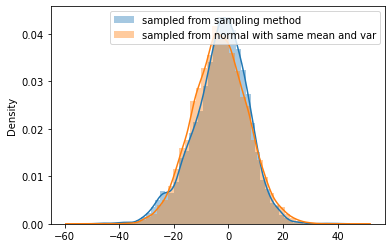

In [598]:
alpha = 1
samples = sample_from_neighbors_continuous(X[:,0:1], jac_dists,noise_type = 'normal', size = 10000, alpha = alpha)
mean,cov = estimate_mean_and_variance_from_neighbors_mixture(X[:,0:1], jac_dists, alpha = alpha)
sns.distplot(samples[0].flatten(), label = 'sampled from sampling method')
sns.distplot(np.random.normal(mean, np.sqrt(cov), 10000), label = 'sampled from normal with same mean and var')
plt.legend()

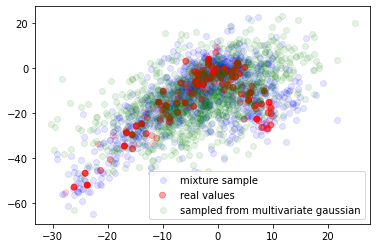

In [599]:
#samples = sample_from_neighbors_continuous(X, jac_dists,noise_type = 'multivariate_normal', size = 1000)
alpha = 2
plt.scatter(*PointwiseGaussianMixture(alpha = alpha).fit(X, jac_dists).sample(1000).T, alpha = 0.1, color = 'b', label = 'mixture sample')
plt.scatter(*X.T, alpha = (1 - jac_dists)**alpha, color = 'r', label = 'real values')

mean,cov = estimate_mean_and_variance_from_neighbors_mixture(X, jac_dists, alpha = alpha)

plt.scatter(*np.random.multivariate_normal(mean, cov, 1000).T, alpha = 0.1, color = 'g', label = 'sampled from multivariate gaussian')
plt.legend()

In [600]:
n_neigbors = 100
#X = 3*np.random.random(n_neigbors).reshape(-1,1)
#jac_dists = np.random.random(n_neigbors)

%timeit sample_from_neighbors_continuous(X, jac_dists, size = 1000, noise_type = 'multivariate_normal')

14.1 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [589]:
%timeit mean,cov = estimate_mean_and_variance_from_neighbors_mixture(X, jac_dists)

369 µs ± 7.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [590]:
%timeit sample_from_neighbors_continuous(X[:,0:1], jac_dists, size = 1000, noise_type = 'normal')

2.44 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [591]:
%timeit PointwiseGaussianMixture().fit(X[:,0:1], jac_dists).sample(1000)

2.3 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

<AxesSubplot:ylabel='Density'>

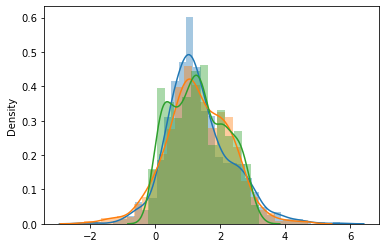

In [592]:
n_neigbors = 100
X = 3*np.random.random(n_neigbors).reshape(-1,1)
jac_dists = np.random.random(n_neigbors)


v1, id1 = sample_from_neighbors_continuous(X, jac_dists, size = 1000, noise_type = 'normal', alpha = 10)
v2, id2 = sample_from_neighbors_continuous(X, jac_dists, size = 1000, noise_type = 'normal', alpha = 1)
v3, id3 = sample_from_neighbors_continuous(X, jac_dists, size = 1000, noise_type = 'normal', alpha = 0.01)

sns.distplot(v1.flatten())
sns.distplot(v2.flatten())
sns.distplot(v3.flatten())

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

<AxesSubplot:ylabel='Density'>

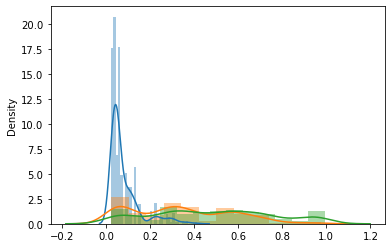

In [593]:
sns.distplot(jac_dists[id1])
sns.distplot(jac_dists[id2])
sns.distplot(jac_dists[id3])

# Export -

In [594]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted dist-checkpoint.ipynb.
Converted estimators-checkpoint.ipynb.
Converted kernel-checkpoint.ipynb.
Converted neighbors-checkpoint.ipynb.
Converted dist.ipynb.
Converted estimators.ipynb.
Converted index.ipynb.
Converted kernel.ipynb.
Converted neighbors.ipynb.
Converted utils.ipynb.
